# Train model phân loại 5 loài động vật 'cat', 'dog', 'elephant', 'horse', 'lion' sử dụng kiến trúc CNN

**link: google colab (Data and jupyter notebook): https://drive.google.com/drive/folders/1uoUC4oMCYdUQcrb2V5W-CXgbzeKRDh2S?usp=sharing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## I. Khảo sát và chuẩn bị dữ liệu

# 1. import các thư viện

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout, Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Đưa ra danh sách các nhãn trong dữ liệu

In [ ]:
# Đưa ra danh sách các thư mục con
train = list(os.walk('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/train'))

In [ ]:
# danh sách các nhãn tương ứng, tạo từ điển với các nhãn
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'horse': 0, 'lion': 1, 'dog': 2, 'elephant': 3, 'cat': 4}


## 3. Tạo tập dữ liệu từ các hình ảnh được lưu trữ trong các thư mục con của đường dẫn

In [ ]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):

        value_of_label = dict_labels[folder]

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/train')
images, labels = shuffle(images, labels)

100%|██████████| 5/5 [01:14<00:00, 14.83s/it]


In [ ]:
# Số lượng và kích thước của tất cả hình ảnh,
images.shape

(13474, 150, 150, 3)

## 4. Trực  quan hóa số lượng dữ liệu của mỗi lớp

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


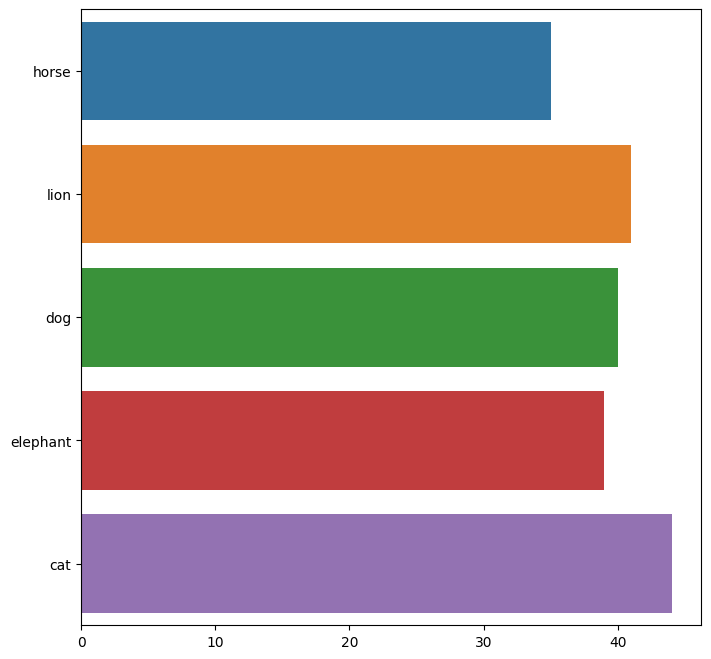

In [ ]:
animals = train[0][1]
no_of_animals = []
for _ in range(0, 5):
    no_of_animals.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = animals, x = no_of_animals);

## 5. Hiển thị 25 hình ảnh đầu tiên của tập dữ liệu

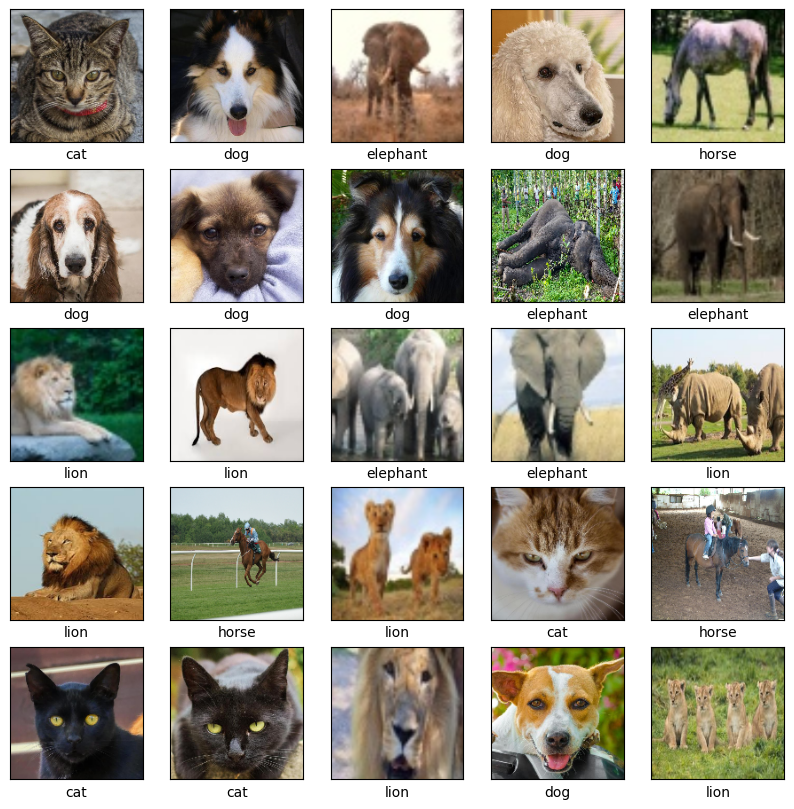

In [ ]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

## 6. Tải dữ liệu cho tập train và test

In [ ]:

train_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/train',
    target_size = (150,150),
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/val',
    target_size = (150,150),
    class_mode = 'categorical'
)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


## 7. Hiển thị 5 hình ảnh đầu tiên của 'train_generator'

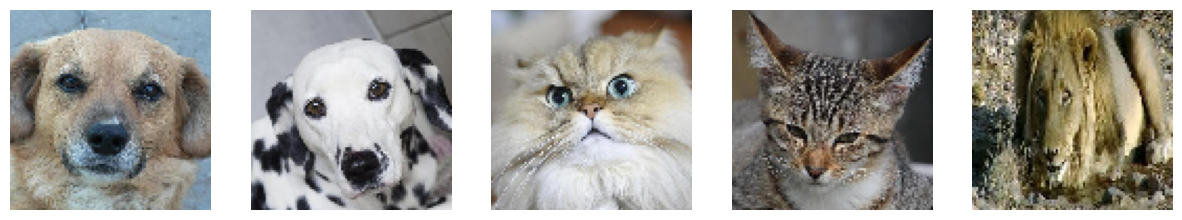

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_generator)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# II. Khởi tạo mô hình với kiến trúc CNN

## 1. Khởi tạo và thêm các lớp vào mô hình

In [ ]:

model = Sequential()
model.add(Conv2D(16,(3,3), input_shape=(150,150,3), padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3), input_shape=(150,150,3), padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3), input_shape=(150,150,3), padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 18, 18, 64)       

## 2. Cấu hình quá trình học cho mô hình

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0007),loss='categorical_crossentropy',metrics=['accuracy'])

## 3. Huấn luyện mô hình

In [ ]:
history = model.fit(train_generator,epochs=3, batch_size=32, validation_data=test_generator)

Epoch 1/3
422/422 [==============================] - 152s 351ms/step - loss: 0.9615 - accuracy: 0.6284 - val_loss: 0.6109 - val_accuracy: 0.7715
Epoch 2/3
422/422 [==============================] - 43s 102ms/step - loss: 0.5932 - accuracy: 0.7729 - val_loss: 0.5457 - val_accuracy: 0.7956
Epoch 3/3
422/422 [==============================] - 44s 105ms/step - loss: 0.4495 - accuracy: 0.8261 - val_loss: 0.5568 - val_accuracy: 0.7709


In [ ]:
history = model.fit(train_generator,epochs=3, batch_size=32, validation_data=test_generator)

Epoch 1/3
422/422 [==============================] - 44s 104ms/step - loss: 0.3337 - accuracy: 0.8700 - val_loss: 0.5005 - val_accuracy: 0.8049
Epoch 2/3
422/422 [==============================] - 43s 102ms/step - loss: 0.2138 - accuracy: 0.9223 - val_loss: 0.4761 - val_accuracy: 0.8210
Epoch 3/3
422/422 [==============================] - 43s 102ms/step - loss: 0.1269 - accuracy: 0.9544 - val_loss: 0.5191 - val_accuracy: 0.8337


# III. Trực quan hóa kết quả sau khi huấn luyện

## 1. Trực quan hóa biểu đồ độ chính xác của mô hình trên tập huấn luyện và kiểm tra

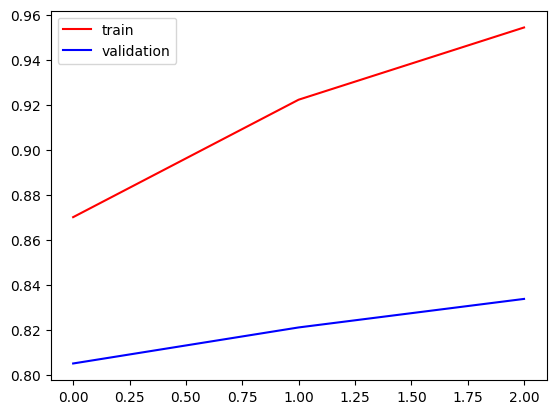

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

## 2. Trực quan hóa giá trị hàm mất mát (loss) trên tập huấn luyện của mô hình và giá trị hàm mất mát tập kiểm thử (val_loss)

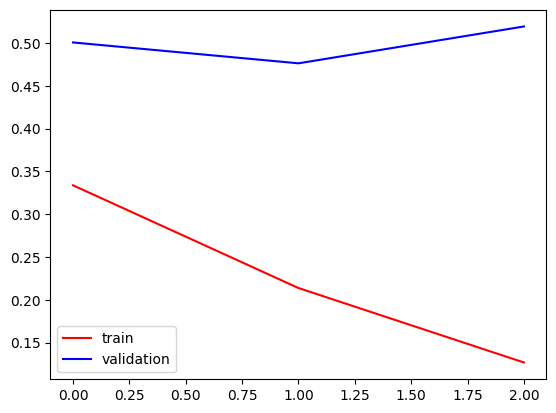

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# 4.Lưu model

In [ ]:
model.save("/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/animal_classifier_cnn.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing đầu ra của model

## 1. Lấy danh sách các nhãn tương ứng với các lớp

In [ ]:
train_generator.class_indices

{'cat': 0, 'dog': 1, 'elephant': 2, 'horse': 3, 'lion': 4}

**lớp động vật:**
* Cat => 0
* Dog => 1
* Elephant => 2
* Horse => 3
* Lion => 4

## 2. Định nghĩa 1 hàm dự đoán lớp của hình ảnh đầu vào

In [ ]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150, 150))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 150,150,3)

    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nAnimal: {1}'.format(clas, name))

## 3. Thực hiện test

**Dog**

1/1 [==============================] - 0s 20ms/step
The given image is of 
Class: 1 
Animal: dog


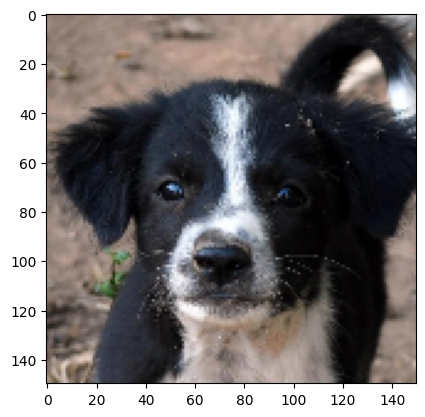

In [ ]:
predictor('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/test/dog110.jpg',model)

**Lion**

1/1 [==============================] - 0s 18ms/step
The given image is of 
Class: 4 
Animal: lion


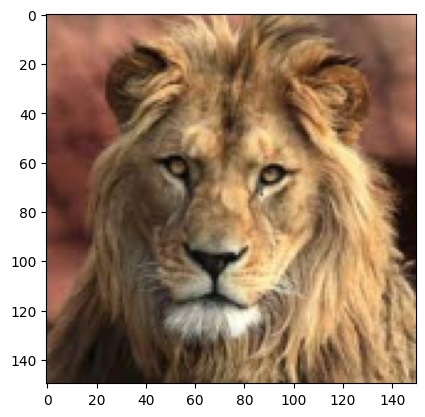

In [ ]:
predictor('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/test/lion.jpg',model)

**Horse**

1/1 [==============================] - 0s 18ms/step
The given image is of 
Class: 3 
Animal: horse


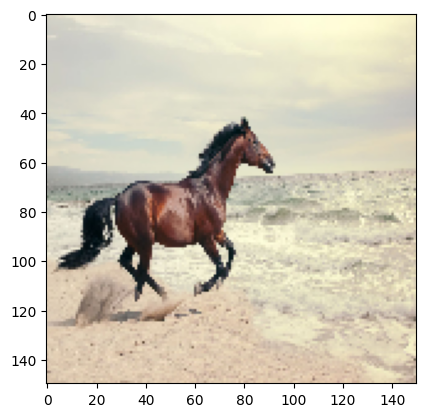

In [ ]:
predictor('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/test/horse.jpg',model)

**Lion**

1/1 [==============================] - 0s 18ms/step
The given image is of 
Class: 4 
Animal: lion


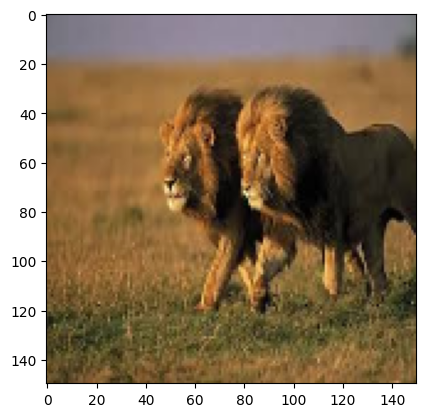

In [ ]:
predictor('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/test/lions.jpg',model)

**Elephant**

1/1 [==============================] - 0s 18ms/step
The given image is of 
Class: 2 
Animal: elephant


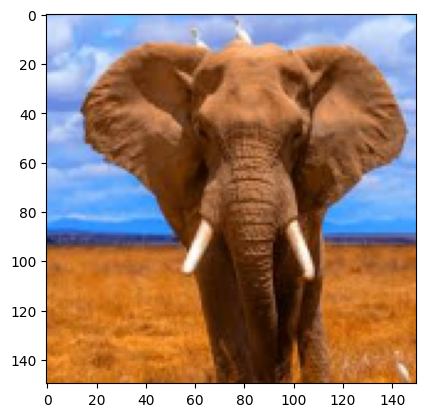

In [ ]:
predictor('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/test/elephant.jpg',model)

**Horse**

1/1 [==============================] - 0s 18ms/step
The given image is of 
Class: 3 
Animal: horse


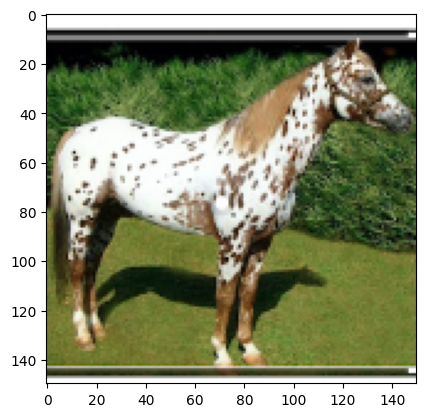

In [ ]:
predictor('/content/drive/MyDrive/Colab_Notebooks/Animal_Classifier/Animal/test/horse104.png',model)